In [1]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Import files

In [2]:
#Import all HDF5 files from a folder. Be careful to be in the filepath, add r'C: to file paths if run in Windows
datafolder = Path(r'import_path') 
df = sorted(list(datafolder.glob('*_featuresN.hdf5')))

In [3]:
#Get timeseries data and assign strain information
data_feat = pd.DataFrame() 
temporary1 = []
for iteration, i in enumerate(df): 
    data = pd.read_hdf(i, 'timeseries_data')
    data = data.assign(Path = i)
    data = data.assign(File = os.path.basename(i))
    a = os.path.basename(i)
    data = data.assign(Strain = a[0:7])
    temporary1.append(data)
data_feat = pd.concat(temporary1, ignore_index = True)
data_feat.shape

(1649238, 156)

In [4]:
#Get trajectory data
traj = pd.DataFrame()
temporary1 = [] 
for iteration, i in enumerate(df): 
    data = pd.read_hdf(i, 'trajectories_data')
    data = data.assign(File = i)
    data = data.assign(File = os.path.basename(i))
    temporary1.append(data)
traj = pd.concat(temporary1, ignore_index = True)
traj.shape #should be same rows as _feat above

(1649238, 16)

In [9]:
#keep only feature(s) you want
feat_vars = pd.DataFrame()

#choose features
feat_vars['coord_x_midbody'] = data_feat['coord_x_midbody']
feat_vars['coord_y_midbody'] = data_feat['coord_y_midbody']

#basic info needed for analysis from _feat
feat_vars['Strain'] = data_feat['Strain']
feat_vars['worm_index'] = data_feat['worm_index']
feat_vars['timestamp'] = data_feat['timestamp']
feat_vars['File'] = data_feat['File']

#basic info needed for analysis from _traj
feat_vars['worm_label'] = traj['worm_label']

feat_vars = feat_vars.astype('int64', errors='ignore')
pd.set_option('display.max_colwidth', None)

feat_vars.head()

,coord_x_midbody,coord_y_midbody,Strain,worm_index,timestamp,File,worm_label
0,22298.847656,29223.300781,N2_LB__,1,0,N2_LB__betA_global_0to5_1_featuresN.hdf5,1
1,22297.091797,29224.767578,N2_LB__,1,1,N2_LB__betA_global_0to5_1_featuresN.hdf5,1
2,22292.048828,29229.316406,N2_LB__,1,2,N2_LB__betA_global_0to5_1_featuresN.hdf5,1
3,22285.226562,29235.910156,N2_LB__,1,3,N2_LB__betA_global_0to5_1_featuresN.hdf5,1
4,22278.154297,29243.310547,N2_LB__,1,4,N2_LB__betA_global_0to5_1_featuresN.hdf5,1


In [10]:
#how many frames per strain?
feat_vars['Strain'].value_counts()

N2_M9__    864135
N2_LB__    785103
Name: Strain, dtype: int64

In [11]:
#dump all trajectories that are not worms (where worm_label is not 1.0)
#note you must have manually assigned worms in tierpsy viewer, otherwise you can ommit this step
feat_vars_worms= feat_vars[feat_vars.worm_label == 1.0]
feat_vars_worms.reset_index(inplace=True)
feat_vars_worms.drop('index', axis=1, inplace=True)
feat_vars_worms.head()

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,coord_x_midbody,coord_y_midbody,Strain,worm_index,timestamp,File,worm_label
0,22298.847656,29223.300781,N2_LB__,1,0,N2_LB__betA_global_0to5_1_featuresN.hdf5,1
1,22297.091797,29224.767578,N2_LB__,1,1,N2_LB__betA_global_0to5_1_featuresN.hdf5,1
2,22292.048828,29229.316406,N2_LB__,1,2,N2_LB__betA_global_0to5_1_featuresN.hdf5,1
3,22285.226562,29235.910156,N2_LB__,1,3,N2_LB__betA_global_0to5_1_featuresN.hdf5,1
4,22278.154297,29243.310547,N2_LB__,1,4,N2_LB__betA_global_0to5_1_featuresN.hdf5,1


In [12]:
#make a unique index for each worm 'strain_video_index'
feat_vars_worms['unique_worm_index'] = feat_vars_worms['File'] + '_' + feat_vars_worms['worm_index'].astype(str)
feat_vars_worms.shape

<ipython-input-12-b9bca589a284>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_vars_worms['unique_worm_index'] = feat_vars_worms['File'] + '_' + feat_vars_worms['worm_index'].astype(str)


(1618250, 8)

In [13]:
#map a coloumn for video timepoints (or other varibale if you have one)
#in this case timepoint data was encoded within the name of the file
def f(row):
    if '0to5' in row['File']:
        val = '5'
    elif '20to25' in row['File']:
        val = '25'
    elif '40to45' in row['File']:
        val = '45'
    elif '1h25to1h30' in row['File']:
        val = '90'
    else:
        val = '0'
    return val

#create new column 'video_timepoint' using the function above
feat_vars_worms['video_timepoint'] = feat_vars_worms.apply(f, axis=1)
feat_vars_worms.head()


<ipython-input-13-f523a3be7811>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_vars_worms['video_timepoint'] = feat_vars_worms.apply(f, axis=1)


,coord_x_midbody,coord_y_midbody,Strain,worm_index,timestamp,File,worm_label,unique_worm_index,video_timepoint
0,22298.847656,29223.300781,N2_LB__,1,0,N2_LB__betA_global_0to5_1_featuresN.hdf5,1,N2_LB__betA_global_0to5_1_featuresN.hdf5_1,5
1,22297.091797,29224.767578,N2_LB__,1,1,N2_LB__betA_global_0to5_1_featuresN.hdf5,1,N2_LB__betA_global_0to5_1_featuresN.hdf5_1,5
2,22292.048828,29229.316406,N2_LB__,1,2,N2_LB__betA_global_0to5_1_featuresN.hdf5,1,N2_LB__betA_global_0to5_1_featuresN.hdf5_1,5
3,22285.226562,29235.910156,N2_LB__,1,3,N2_LB__betA_global_0to5_1_featuresN.hdf5,1,N2_LB__betA_global_0to5_1_featuresN.hdf5_1,5
4,22278.154297,29243.310547,N2_LB__,1,4,N2_LB__betA_global_0to5_1_featuresN.hdf5,1,N2_LB__betA_global_0to5_1_featuresN.hdf5_1,5


In [241]:
#use this if you want to crop video length
#dump all timestamps over the max video length
video_length = 7500 #in frames
indexNames = feat_vars_worms[(feat_vars_worms['timestamp'] > video_length)].index
feat_vars_worms.drop(indexNames , inplace=True)
frames = feat_vars_worms.timestamp.unique()
maxframes = frames[-1]
print ('max frames:', maxframes)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1618250, 9)

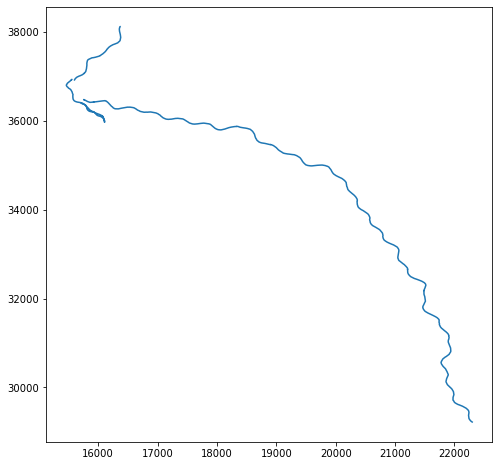

In [22]:
#view an example track
test_df = feat_vars_worms.loc[feat_vars_worms.unique_worm_index == 'N2_LB__betA_global_0to5_1_featuresN.hdf5_1'] #select a unique worm id here
#plot
plt.figure(figsize=(8, 8))
plt.plot(test_df['coord_x_midbody'], test_df['coord_y_midbody'])

<ipython-input-23-a91ee0a1a077>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['coord_x_midbody_rol'] = test_df['coord_x_midbody'].rolling(50).mean()
<ipython-input-23-a91ee0a1a077>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['coord_y_midbody_rol'] = test_df['coord_y_midbody'].rolling(50).mean()


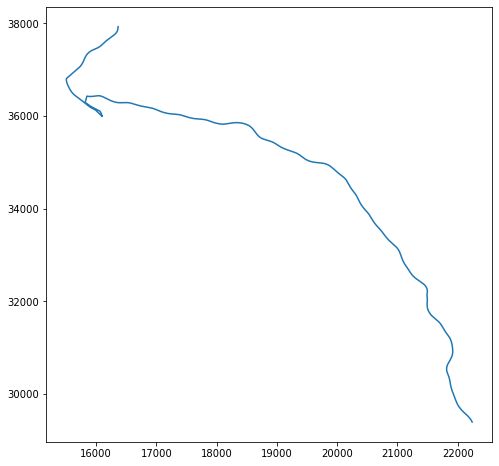

In [23]:
#view the same example interpolated and smoothed track
test_df['coord_x_midbody_rol'] = test_df['coord_x_midbody'].rolling(50).mean()
test_df['coord_y_midbody_rol'] = test_df['coord_y_midbody'].rolling(50).mean()
test_df = test_df.interpolate()
#plot
plt.figure(figsize=(8, 8))
plt.plot(test_df['coord_x_midbody_rol'], test_df['coord_y_midbody_rol'])

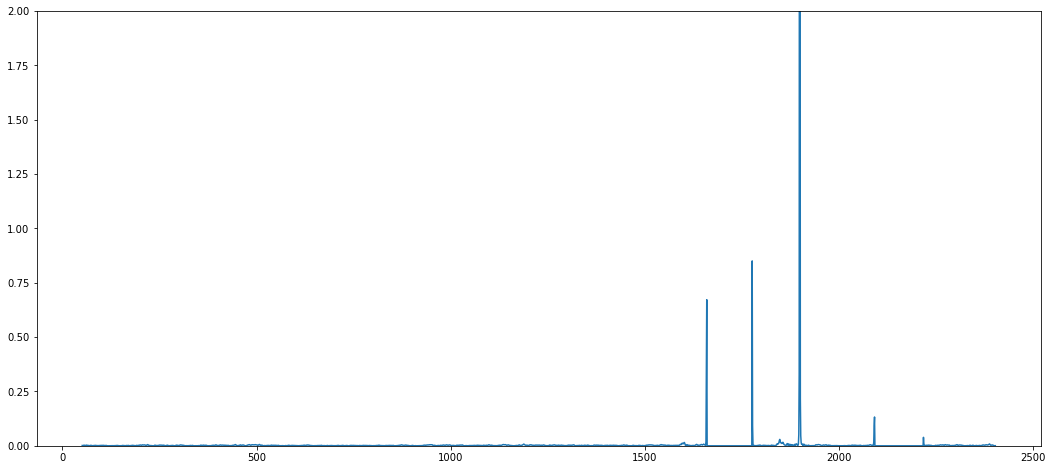

In [24]:
#calc curvature for example and plot
df_curvature = pd.DataFrame()

coordinates = test_df[['coord_x_midbody_rol', 'coord_y_midbody_rol']].to_numpy() 

x_t = np.gradient(coordinates[:, 0])
y_t = np.gradient(coordinates[:, 1])

vel = np.array([ [x_t[i], y_t[i]] for i in range(x_t.size)])
speed = np.sqrt(x_t * x_t + y_t * y_t)

ss_t = np.gradient(speed)
xx_t = np.gradient(x_t)
yy_t = np.gradient(y_t)

curvature_val = np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5

df_curvature['curvature'] = curvature_val

plt.figure(figsize=(18, 8))
plt.ylim(0,2)
plt.plot(df_curvature.index, df_curvature['curvature'])

In [25]:
#count number of reorientations for example 1=reorinetation
df_curvature['curv_high'] = np.where(df_curvature['curvature'] >= 0.25, '1', '0')
df_curvature['curv_high']=pd.to_numeric(df_curvature['curv_high'])
df_curvature['curv_high_diff'] = df_curvature['curv_high'].diff()
df_curvature['reorientation'] = np.where((df_curvature['curv_high_diff'] == 1), 1, 0)
df_curvature['reorientation'].value_counts()

0    2400
1       3
Name: reorientation, dtype: int64

In [26]:
#apply to all data
framerate = 25
min_length = 30 * framerate #number is in seconds
window = 50 #rolling mean window size in frames 

#get list of unique IDs
worm_list = feat_vars_worms.unique_worm_index.unique()

#set up lists and dfs
curv_data_raw = pd.DataFrame()
curv_data = pd.DataFrame()
reorientations = []
unique_worm_index = []
path_time = []
maxtime = []

#find peaks
for worm in worm_list:
    current_worm = feat_vars_worms.loc[feat_vars_worms.unique_worm_index == worm]
    current_worm = current_worm.loc[:,['timestamp', 'coord_x_midbody', 'coord_y_midbody']]

    current_worm.reset_index(inplace=True)
    current_worm = current_worm.drop(columns = ['index'])
    current_worm.reset_index(inplace=True)
    current_worm = current_worm.rename(columns = {'index':'time_norm'})
    
    if len(current_worm) >= min_length:
        current_worm['coord_x_midbody_rol'] = current_worm['coord_x_midbody'].rolling(window).mean()
        current_worm['coord_y_midbody_rol'] = current_worm['coord_y_midbody'].rolling(window).mean()
        current_worm = current_worm.interpolate()
        coordinates = current_worm[['coord_x_midbody_rol', 'coord_y_midbody_rol']].to_numpy() 
        x_t = np.gradient(coordinates[:, 0])
        y_t = np.gradient(coordinates[:, 1])
        vel = np.array([ [x_t[i], y_t[i]] for i in range(x_t.size)])
        speed = np.sqrt(x_t * x_t + y_t * y_t)
        ss_t = np.gradient(speed)
        xx_t = np.gradient(x_t)
        yy_t = np.gradient(y_t)
        curvature_val = np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5

        #get time of track
        maxtime = len(current_worm)

        #raw data
        curv_data_raw = pd.DataFrame(curvature_val, columns=["curv"])
        curv_data_raw['curv_high'] = np.where(curv_data_raw["curv"] >= 0.25, '1', '0')
        curv_data_raw['curv_high']=pd.to_numeric(curv_data_raw['curv_high'])
        curv_data_raw['curv_high_diff'] = curv_data_raw['curv_high'].diff()
        curv_data_raw['reorientation'] = np.where((curv_data_raw['curv_high_diff'] == 1), 1, 0)  
        no_turns = curv_data_raw['reorientation'].sum()

        #for summary
        unique_worm_index.append(worm)
        reorientations.append(no_turns)
        path_time.append(maxtime)

curv_data['unique_worm_index'] = unique_worm_index
curv_data['reorientations'] = reorientations
curv_data['path_time'] = path_time
curv_data['reorientations_per_min'] = curv_data['reorientations'] / (curv_data['path_time']/framerate/60)

curv_data.head()

<ipython-input-26-5597d606ede6>:39: RuntimeWarning: invalid value encountered in true_divide
  curvature_val = np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
<ipython-input-26-5597d606ede6>:39: RuntimeWarning: invalid value encountered in true_divide
  curvature_val = np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
<ipython-input-26-5597d606ede6>:39: RuntimeWarning: invalid value encountered in true_divide
  curvature_val = np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
<ipython-input-26-5597d606ede6>:39: RuntimeWarning: invalid value encountered in true_divide
  curvature_val = np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
<ipython-input-26-5597d606ede6>:39: RuntimeWarning: invalid value encountered in true_divide
  curvature_val = np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
<ipython-input-26-5597d606ede6>:39: RuntimeWarning: invalid value encountered in true_divide
  curvature_val = np.abs(xx_t * y_t -

,unique_worm_index,reorientations,path_time,reorientations_per_min
0,N2_LB__betA_global_0to5_1_featuresN.hdf5_1,3,2403,1.872659
1,N2_LB__betA_global_0to5_1_featuresN.hdf5_2,4,3104,1.932990
2,N2_LB__betA_global_0to5_1_featuresN.hdf5_3,20,7439,4.032800
3,N2_LB__betA_global_0to5_1_featuresN.hdf5_4,7,3020,3.476821
4,N2_LB__betA_global_0to5_1_featuresN.hdf5_5,9,4678,2.885849


In [28]:
#create new column 'video_timepoint' using the function above
curv_data['video_timepoint'] = curv_data.apply(f, axis=1)

Strains = []
for name in curv_data['unique_worm_index']:
    Strain = name[0:7]
    Strains.append(Strain)

curv_data['Strain'] = Strains
curv_data.head()

,unique_worm_index,reorientations,path_time,reorientations_per_min,video_timepoint,Strain
0,N2_LB__betA_global_0to5_1_featuresN.hdf5_1,3,2403,1.872659,5,N2_LB__
1,N2_LB__betA_global_0to5_1_featuresN.hdf5_2,4,3104,1.932990,5,N2_LB__
2,N2_LB__betA_global_0to5_1_featuresN.hdf5_3,20,7439,4.032800,5,N2_LB__
3,N2_LB__betA_global_0to5_1_featuresN.hdf5_4,7,3020,3.476821,5,N2_LB__
4,N2_LB__betA_global_0to5_1_featuresN.hdf5_5,9,4678,2.885849,5,N2_LB__


In [229]:
#select an optional filter
#curv_data_filtered = curv_data_filtered.loc[curv_data_filtered['path_time'] > (25*120)]

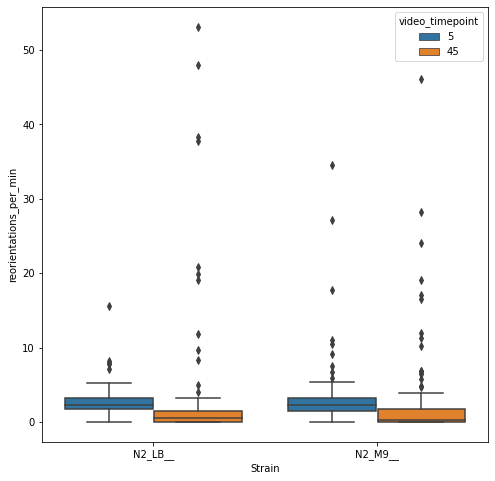

In [30]:
plt.figure(figsize=(8, 8))
#plt.ylim(0,25)
ax = sns.boxplot(x="Strain", y="reorientations_per_min", data=curv_data, hue='video_timepoint')

In [250]:
#export data to .csv
curv_data.to_csv(r'export_path.csv')